<a href="https://colab.research.google.com/github/marianoaloi/paligemma/blob/main/capacete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adapted from:
#[paligemma](https://ai.google.dev/gemma/docs/paligemma/fine-tuning-paligemma)

In [1]:
import os
from google.colab import userdata

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

In [2]:
import sys


if "COLAB_TPU_ADDR" in os.environ:
  raise "It seems you are using Colab with remote TPUs which is not supported."

if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 6.7 MB/s eta 0:00:00


In [3]:
import base64
import functools
import html
import io
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding

# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.lib.xla_bridge.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")
print(f"JAX available devices:  {jax.devices()}")

JAX version:  0.4.26
JAX platform: gpu
JAX devices:  1
JAX available devices:  [cuda(id=0)]


In [4]:
import kagglehub

MODEL_PATH = "./mix-448_128.params.f16.npz"
if not os.path.exists(MODEL_PATH):
  print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
  # Note: kaggle archive contains the same checkpoint in multiple formats.
  # Download only the float16 model.
  MODEL_PATH = kagglehub.model_download('google/paligemma/jax/paligemma-3b-mix-448', 'paligemma-3b-mix-448.f16.npz')
  print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
  print("Downloading the model tokenizer...")
  !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
  print(f"Tokenizer path: {TOKENIZER_PATH}")

DATA_DIR="./capacete"
if not os.path.exists(DATA_DIR):
  print("Downloading the dataset...")
  # !gsutil -m -q cp -n -r gs://longcap100/ .
  !git clone https://github.com/marianoaloi/paligemma.git
  !mv ./paligemma/capacete/ .
  print(f"Data path: {DATA_DIR}")

100%|██████████| 5.45G/5.45G [06:02<00:00, 16.2MB/s]


Model path: /root/.cache/kagglehub/models/google/paligemma/jax/paligemma-3b-mix-448/1/paligemma-3b-mix-448.f16.npz
Copying gs://big_vision/paligemma_tokenizer.model...
| [1 files][  4.1 MiB/  4.1 MiB]                                                
Operation completed over 1 objects/4.1 MiB.                                      
Tokenizer path: ./paligemma_tokenizer.model
Cloning into 'paligemma'...
remote: Enumerating objects: 249, done.
remote: Counting objects: 100% (249/249), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 249 (delta 57), reused 220 (delta 36), pack-reused 0
Receiving objects: 100% (249/249), 9.60 MiB | 5.82 MiB/s, done.
Resolving deltas: 100% (57/57), done.
Data path: ./capacete


In [5]:
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

params = paligemma.load(None, MODEL_PATH, model_config)

decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

print(" == Model Original params == ")
parameter_overview(params)

 == Model Original params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                      

In [6]:
# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  return jax.tree.map(lambda p, m: p.astype(jnp.float32) if m else p,
                      params, trainable)



# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default.
# Instead we do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)


print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

Training examples



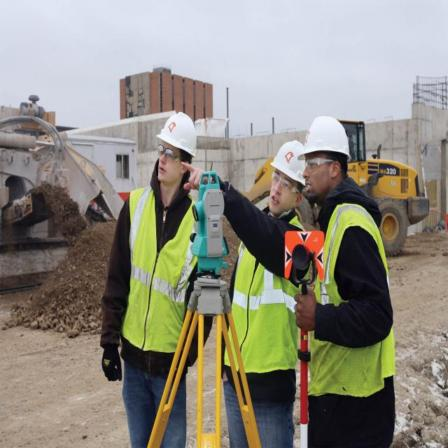
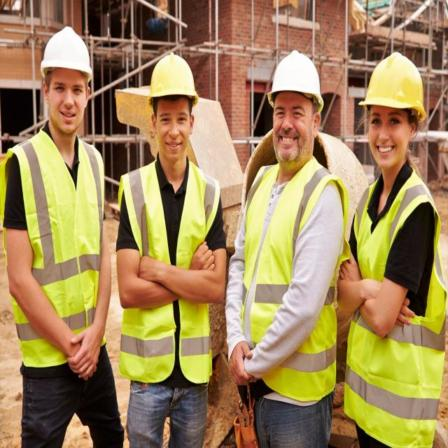
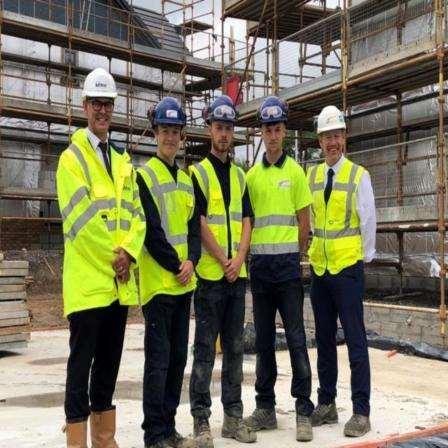
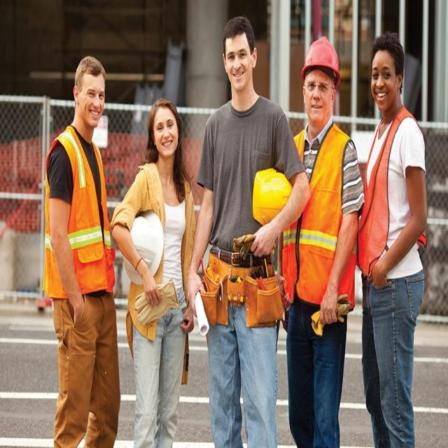
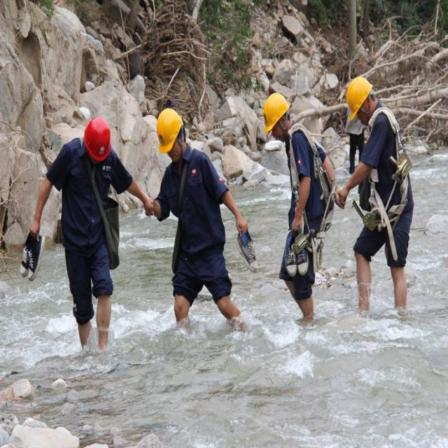
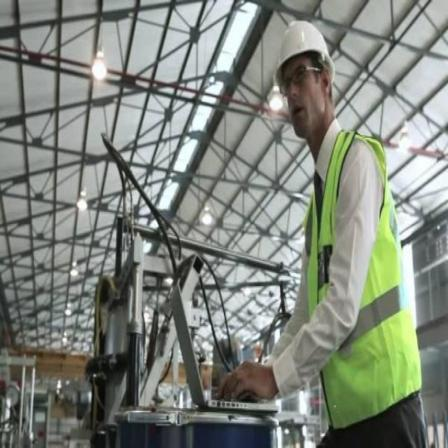
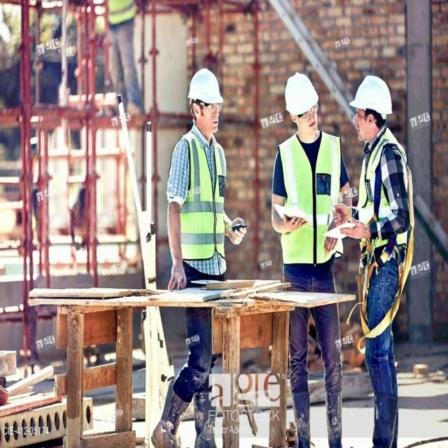
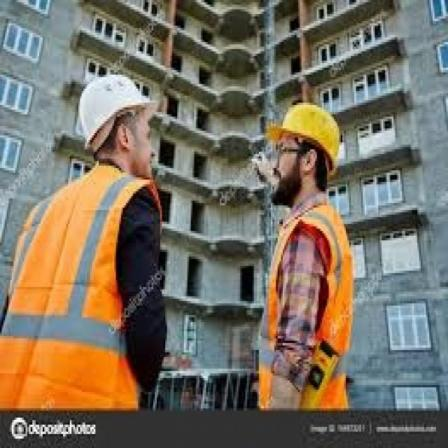

In [7]:
def preprocess_image(image, size=448):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
  # Model has been trained to handle tokenized text composed of a prefix with
  # full attention and a suffix with causal attention.
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
  mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
    mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

  mask_input = [1] * len(tokens)    # 1 if it's a token, 0 if padding.
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)
# %%
SEQLEN = 128

train_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(DATA_DIR, "data_train90.jsonl"),
    fopen_keys={"image": DATA_DIR})

val_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(DATA_DIR, "data_val10.jsonl"),
    fopen_keys={"image": DATA_DIR})

test_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(DATA_DIR, "test.jsonl"),
    fopen_keys={"image": DATA_DIR})

def train_data_iterator():
  """Never ending iterator over training examples."""
  # Shuffle examples and repeat so one can train for many epochs.
  dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()
  for example in dataset.as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    prefix = example["prefix"].decode().lower() #"caption en"  # Could also be a different prefix per example.
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_loss": np.asarray(mask_loss),
    }


def validation_data_iterator():
  """Single iterator over validation examples."""
  for example in val_dataset.get_tfdata(ordered=True).as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    prefix = example["prefix"].decode().lower() #"caption en"  # Could also be a different prefix per example.
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_input": np.asarray(mask_input),
    }


def test_data_iterator():
  """Single iterator over validation examples."""
  for example in test_dataset.get_tfdata(ordered=True).as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    prefix = example["prefix"].decode().lower() #"caption en"  # Could also be a different prefix per example.
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_input": np.asarray(mask_input),
    }

def render_inline(image, resize=(128, 128)):
  """Convert image into inline html."""
  image = Image.fromarray(image)
  image.resize(resize)
  with io.BytesIO() as buffer:
    image.save(buffer, format='jpeg')
    image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
    return f"data:image/jpeg;base64,{image_b64}"

def render_example(image, caption):
  image = ((image + 1)/2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
  return f"""
    <div style="display: inline-flex; align-items: center; justify-content: center;">
        <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
        <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
    </div>
    """

html_out = ""
for idx, example in zip(range(8), train_data_iterator()):
  caption = postprocess_tokens(example["text"])  # detokenize model input.
  # caption = caption[caption.rfind("?")+1:]        # strip prefix
  html_out += render_example(example["image"], caption)

print("Training examples")
display(HTML(html_out))

In [8]:

# The main update_fn using a simple stochastic gradient descent (SGD).
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    # are part of the loss (e.g. prefix and padded tokens are not included).
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example. i.e. the mean of per token pplx.
    # Since each example has a different number of tokens we normalize it.
    token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

    # batch_loss: mean of per example loss.
    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  # Apply gradients to trainable params using SGD.
  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

# Evaluation/inference loop.
def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:
    # Construct a list of examples in the batch.
    examples = []
    try:
      for _ in range(batch_size):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)  # Indicates true example.
    except StopIteration:
      if len(examples) == 0:
        return outputs

    # Not enough examples to complete a batch. Pad by repeating last example.
    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)

    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]  # remove padding examples.
    responses = [postprocess_tokens(t) for t in tokens]

    # Append to html output.
    for example, response in zip(examples, responses):
      outputs.append((example["image"], response))
      if num_examples and len(outputs) >= num_examples:
        return outputs

In [9]:
BATCH_SIZE = 8
TRAIN_EXAMPLES = 2024 # 512
LEARNING_RATE = 0.01

TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS = TRAIN_STEPS // 4

train_data_it = train_data_iterator()

sched_fn = big_vision.utils.create_learning_rate_schedule(
    total_steps=TRAIN_STEPS+1, base=LEARNING_RATE,
    decay_type="cosine", warmup_percent=0.10)

step:  1/253   lr: 0.00040   loss: 3.3378
step:  2/253   lr: 0.00080   loss: 3.2577
step:  3/253   lr: 0.00120   loss: 2.7495
step:  4/253   lr: 0.00160   loss: 2.7961
step:  5/253   lr: 0.00200   loss: 2.6739
step:  6/253   lr: 0.00240   loss: 2.7365
step:  7/253   lr: 0.00280   loss: 2.4951
step:  8/253   lr: 0.00320   loss: 2.4404
step:  9/253   lr: 0.00360   loss: 2.3987
step: 10/253   lr: 0.00400   loss: 2.3125
step: 11/253   lr: 0.00440   loss: 2.3648
step: 12/253   lr: 0.00480   loss: 2.0852
step: 13/253   lr: 0.00520   loss: 1.9537
step: 14/253   lr: 0.00560   loss: 2.0596
step: 15/253   lr: 0.00600   loss: 1.9830
step: 16/253   lr: 0.00640   loss: 2.1103
step: 17/253   lr: 0.00680   loss: 2.2917
step: 18/253   lr: 0.00720   loss: 1.9957
step: 19/253   lr: 0.00760   loss: 1.9902
step: 20/253   lr: 0.00800   loss: 1.7545
step: 21/253   lr: 0.00840   loss: 2.0040
step: 22/253   lr: 0.00880   loss: 1.8182
step: 23/253   lr: 0.00920   loss: 1.6838
step: 24/253   lr: 0.00960   loss:


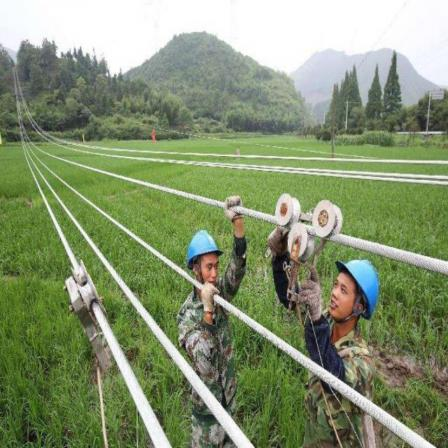
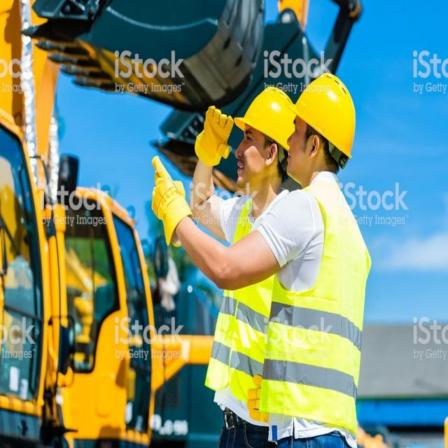
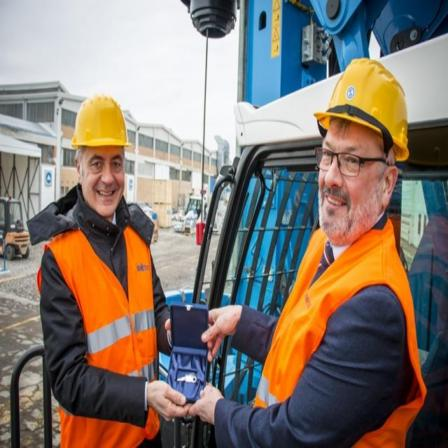
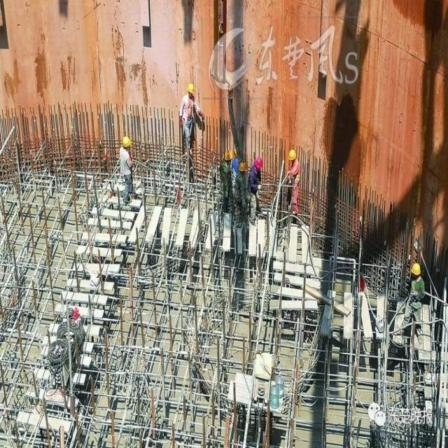

step: 64/253   lr: 0.00930   loss: 1.1348
step: 65/253   lr: 0.00927   loss: 1.0418
step: 66/253   lr: 0.00923   loss: 1.0410
step: 67/253   lr: 0.00919   loss: 1.0250
step: 68/253   lr: 0.00915   loss: 1.3210
step: 69/253   lr: 0.00912   loss: 0.9220
step: 70/253   lr: 0.00908   loss: 0.9741
step: 71/253   lr: 0.00904   loss: 0.8450
step: 72/253   lr: 0.00900   loss: 1.0094
step: 73/253   lr: 0.00895   loss: 0.9246
step: 74/253   lr: 0.00891   loss: 1.0208
step: 75/253   lr: 0.00887   loss: 1.0460
step: 76/253   lr: 0.00883   loss: 0.9827
step: 77/253   lr: 0.00878   loss: 1.0018
step: 78/253   lr: 0.00874   loss: 1.0887
step: 79/253   lr: 0.00869   loss: 1.0767
step: 80/253   lr: 0.00864   loss: 0.7074
step: 81/253   lr: 0.00860   loss: 0.9020
step: 82/253   lr: 0.00855   loss: 0.9465
step: 83/253   lr: 0.00850   loss: 0.7720
step: 84/253   lr: 0.00845   loss: 1.0891
step: 85/253   lr: 0.00840   loss: 0.8762
step: 86/253   lr: 0.00835   loss: 0.9469
step: 87/253   lr: 0.00830   loss:


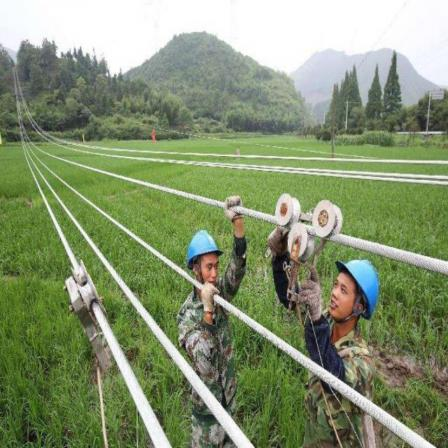
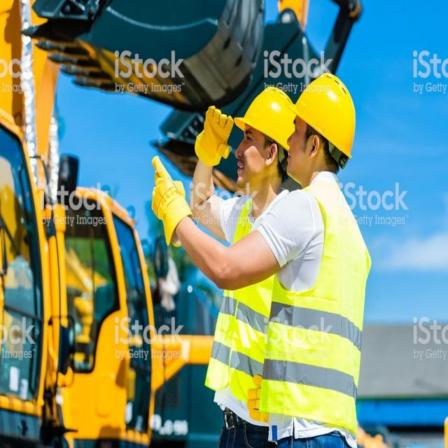
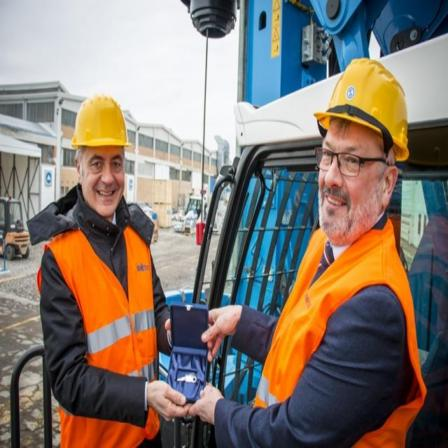
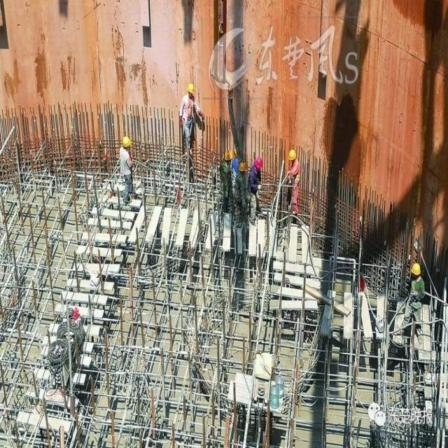

step: 127/253   lr: 0.00585   loss: 0.5834
step: 128/253   lr: 0.00579   loss: 0.6640
step: 129/253   lr: 0.00572   loss: 0.5047
step: 130/253   lr: 0.00565   loss: 0.3864
step: 131/253   lr: 0.00558   loss: 0.4255
step: 132/253   lr: 0.00551   loss: 0.5265
step: 133/253   lr: 0.00545   loss: 0.3966
step: 134/253   lr: 0.00538   loss: 0.4757
step: 135/253   lr: 0.00531   loss: 0.4607
step: 136/253   lr: 0.00524   loss: 0.2545
step: 137/253   lr: 0.00517   loss: 0.3412
step: 138/253   lr: 0.00510   loss: 0.4030
step: 139/253   lr: 0.00503   loss: 0.3028
step: 140/253   lr: 0.00497   loss: 0.3253
step: 141/253   lr: 0.00490   loss: 0.4884
step: 142/253   lr: 0.00483   loss: 0.3646
step: 143/253   lr: 0.00476   loss: 0.3867
step: 144/253   lr: 0.00469   loss: 0.4485
step: 145/253   lr: 0.00462   loss: 0.4181
step: 146/253   lr: 0.00455   loss: 0.2666
step: 147/253   lr: 0.00449   loss: 0.2980
step: 148/253   lr: 0.00442   loss: 0.2856
step: 149/253   lr: 0.00435   loss: 0.2509
step: 150/2


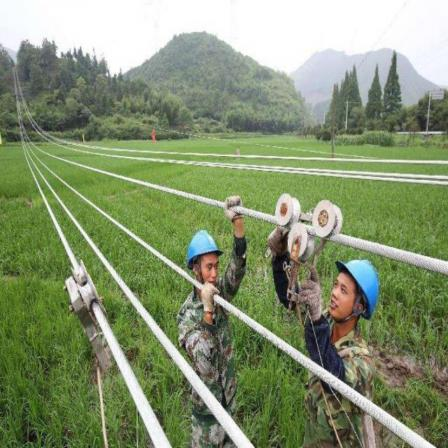
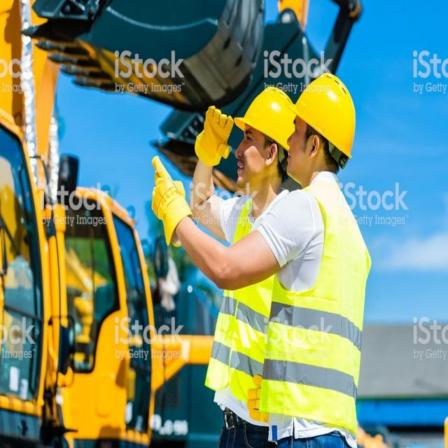
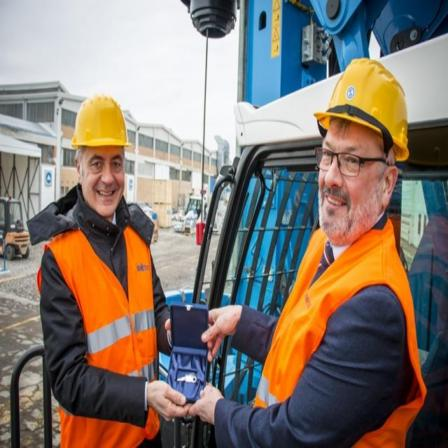
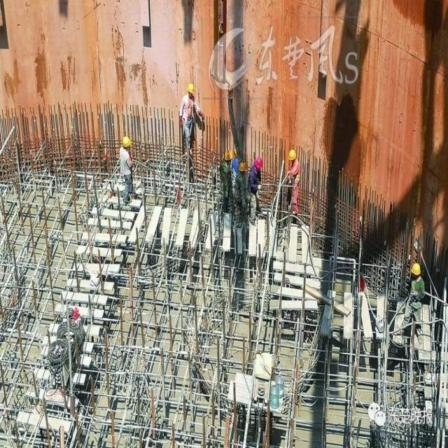

step: 190/253   lr: 0.00181   loss: 0.0697
step: 191/253   lr: 0.00175   loss: 0.0907
step: 192/253   lr: 0.00170   loss: 0.1380
step: 193/253   lr: 0.00165   loss: 0.0809
step: 194/253   lr: 0.00160   loss: 0.0702
step: 195/253   lr: 0.00155   loss: 0.1165
step: 196/253   lr: 0.00150   loss: 0.1204
step: 197/253   lr: 0.00145   loss: 0.0835
step: 198/253   lr: 0.00140   loss: 0.1588
step: 199/253   lr: 0.00136   loss: 0.1583
step: 200/253   lr: 0.00131   loss: 0.1082
step: 201/253   lr: 0.00126   loss: 0.1760
step: 202/253   lr: 0.00122   loss: 0.1175
step: 203/253   lr: 0.00117   loss: 0.1047
step: 204/253   lr: 0.00113   loss: 0.0809
step: 205/253   lr: 0.00109   loss: 0.0794
step: 206/253   lr: 0.00105   loss: 0.1652
step: 207/253   lr: 0.00100   loss: 0.1808
step: 208/253   lr: 0.00096   loss: 0.0849
step: 209/253   lr: 0.00092   loss: 0.1459
step: 210/253   lr: 0.00088   loss: 0.1204
step: 211/253   lr: 0.00085   loss: 0.0619
step: 212/253   lr: 0.00081   loss: 0.0855
step: 213/2


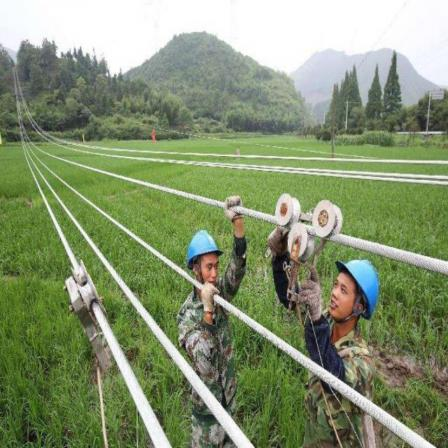
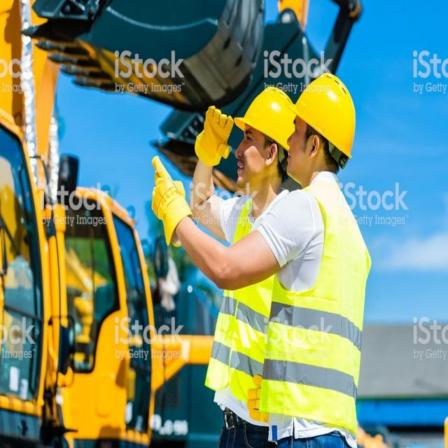
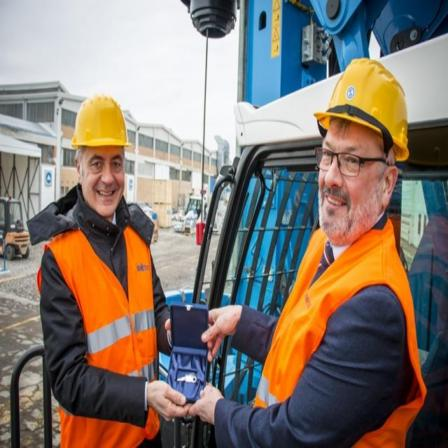
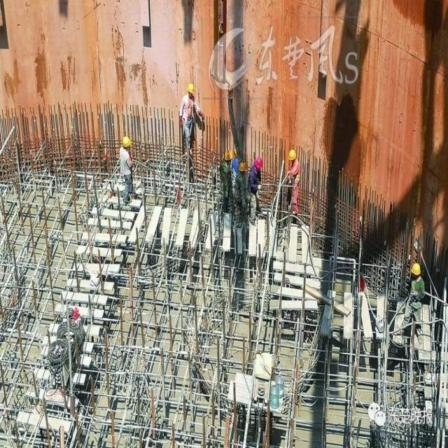

step: 253/253   lr: 0.00000   loss: 0.1373


In [10]:
for step in range(1, TRAIN_STEPS+1):
  # Make list of N training examples.
  examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

  # Convert list of examples into a dict of np.arrays and load onto devices.
  batch = jax.tree.map(lambda *x: np.stack(x), *examples)
  batch = big_vision.utils.reshard(batch, data_sharding)

  # Training step and report training loss
  learning_rate = sched_fn(step)
  params, loss = update_fn(params, batch, learning_rate)

  loss = jax.device_get(loss)
  print(f"step: {step:2d}/{TRAIN_STEPS:2d}   lr: {learning_rate:.5f}   loss: {loss:.4f}")

  if (step % EVAL_STEPS) == 0:
    print(f"Model predictions at step {step}")
    html_out = ""
    for image, caption in make_predictions(
        validation_data_iterator(), num_examples=4, batch_size=4):
      html_out += render_example(image, caption)
    display(HTML(html_out))

Model predictions



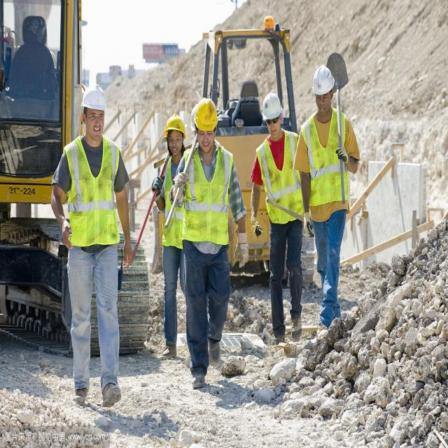
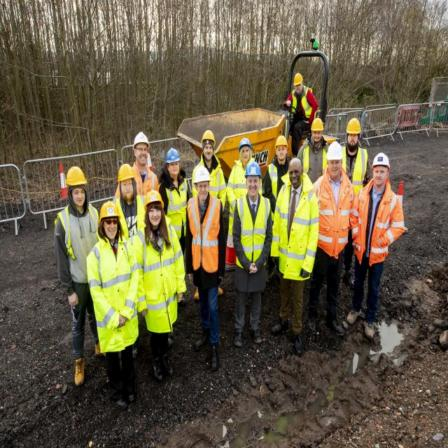
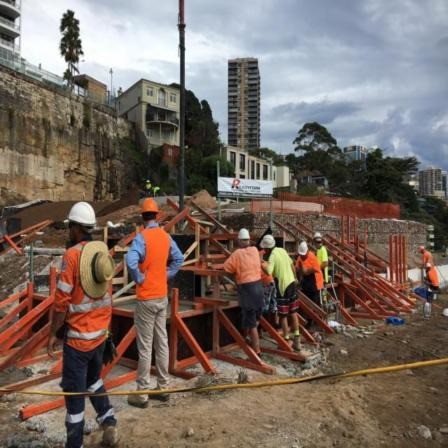
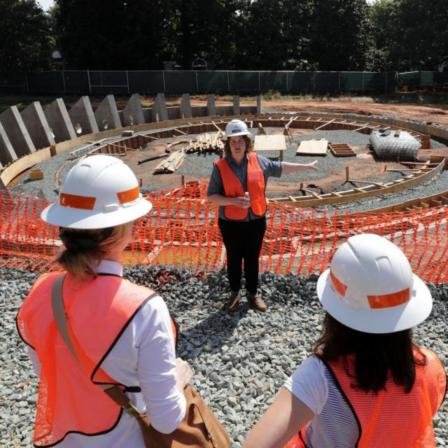
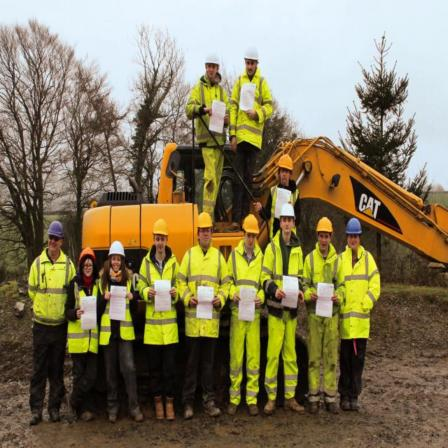
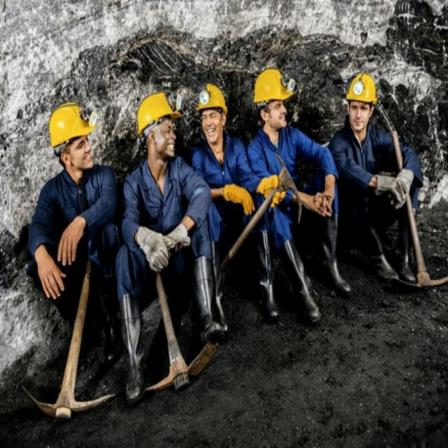
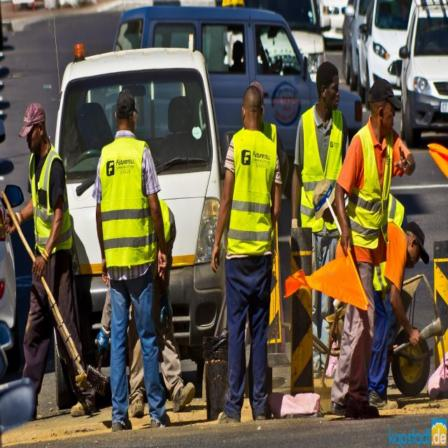
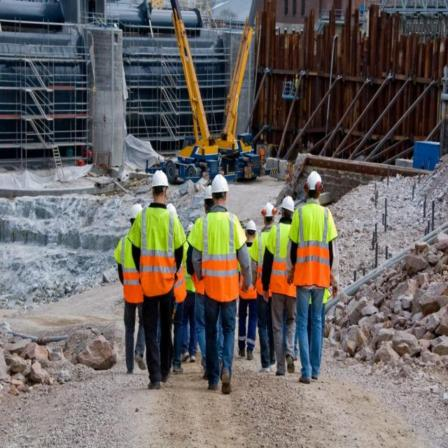
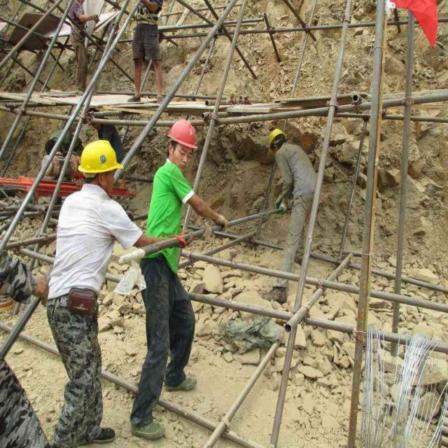
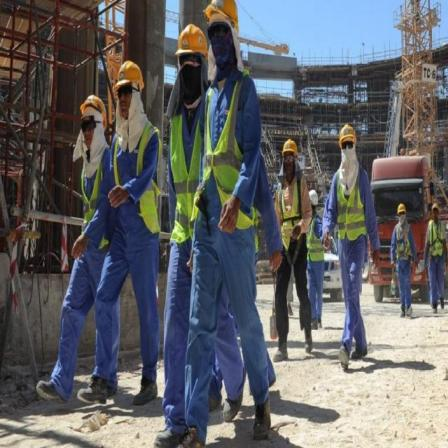

In [11]:
print("Model predictions")
html_out = ""
for image, caption in make_predictions(test_data_iterator(), batch_size=4):
  html_out += render_example(image, caption)
display(HTML(html_out))